In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [2]:
#set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
#define function to process and model a stock using an LSTM architecture
def run_lstm_for_stock(ticker, stock_name):
    #download stock data
    df = yf.download(ticker, start='2010-01-01', end='2025-03-31')

    #generate 5-day and 10-day moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()

    #calculate daily return as percent change
    df['Return'] = df['Close'].pct_change()

    #calculate 14-day RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    #drop any rows with NaN values created from moving averages and RSI calculation
    df.dropna(inplace=True)

    #select features to use for modeling
    features = ['Close', 'MA5', 'MA10', 'Return', 'RSI']

    #split into training (up to 2024) and testing (Q1 2025) datasets
    train_df = df.loc[:'2024-12-31']
    test_df = df.loc['2025-01-01':'2025-03-31']
    real_price_df = df.loc['2025-01-01':'2025-03-31'].copy()

    #apply MinMaxScaler ONLY to training data to prevent data leakage
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_df[features])
    scaled_test = scaler.transform(test_df[features])

    #combine scaled train and test back into one dataframe for sequencing
    scaled_df = pd.concat([
        pd.DataFrame(scaled_train, columns=features, index=train_df.index),
        pd.DataFrame(scaled_test, columns=features, index=test_df.index)
    ])

    #create sequences of lookback size (60 days) to feed into LSTM
    def create_sequences(data, target_index=0):
        x, y = [], []
        for i in range(lookback, len(data)):
            x.append(data[i-lookback:i])
            y.append(data[i, target_index])
        return np.array(x), np.array(y)

    lookback = 60
    x_train, y_train = create_sequences(scaled_train)
    x_test, _ = create_sequences(np.concatenate([scaled_train[-lookback:], scaled_test]))

    #reshape inputs to be 3D [samples, timesteps, features] for LSTM
    x_train = x_train.reshape((x_train.shape[0], lookback, x_train.shape[2]))
    x_test = x_test.reshape((x_test.shape[0], lookback, x_test.shape[2]))

    #define LSTM model architecture
    model = Sequential()
    model.add(Input(shape=(lookback, x_train.shape[2]))) #input layer
    model.add(LSTM(128, return_sequences=True)) #first LSTM layer
    model.add(LSTM(64, return_sequences=False)) #second LSTM layer
    model.add(Dense(25, activation='relu')) #dense layer with ReLU activation
    model.add(Dense(1)) #output layer to predict next day's close price
    model.compile(optimizer='adam', loss='mean_squared_error') #compile model

    #show model summary and plot architecture
    model.summary()
    plot_model(model, show_shapes=True, show_layer_names=True)

    #train model on training data
    model.fit(x_train, y_train, batch_size=1, epochs=10, verbose=1)

    #predict on the testing data
    pred_scaled = model.predict(x_test)

    #set up scaler for only the 'Close' feature for inverse transformation
    close_index = features.index('Close')
    close_scaler = MinMaxScaler()
    close_scaler.min_, close_scaler.scale_ = scaler.min_[close_index], scaler.scale_[close_index]

    #convert predicted scaled values back to real closing prices
    predicted_close = close_scaler.inverse_transform(pred_scaled)

    #add predictions to real prices dataframe for comparison
    real_price_df['Predicted_Close'] = predicted_close

    #calculate evaluation metrics: MAE, RMSE, R^2
    mae = mean_absolute_error(real_price_df['Close'], real_price_df['Predicted_Close'])
    rmse = np.sqrt(mean_squared_error(real_price_df['Close'], real_price_df['Predicted_Close']))
    r2 = r2_score(real_price_df['Close'], real_price_df['Predicted_Close'])

    #calculate directional accuracy (whether model correctly predicts up or down movement)
    actual_diff = real_price_df['Close'].diff().dropna().values
    pred_diff = real_price_df['Predicted_Close'].diff().dropna().values
    actual_sign = np.sign(actual_diff)
    pred_sign = np.sign(pred_diff)
    min_len = min(len(actual_sign), len(pred_sign))
    dir_acc = np.mean(actual_sign[:min_len] == pred_sign[:min_len])

    #package results into dictionary to return
    summary = {
        'stock': stock_name,
        'df': real_price_df,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'directional_accuracy': dir_acc
    }

    return summary

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,667 (467.45 KB)

 Trainable params: 119,667 (467.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 106s 28ms/step - loss: 0.0027
Epoch 2/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 98s 27ms/step - loss: 4.0300e-04
Epoch 3/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 99s 27ms/step - loss: 2.4483e-04
Epoch 4/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 98s 26ms/step - loss: 1.9218e-04
Epoch 5/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 98s 26ms/step - loss: 1.6023e-04
Epoch 6/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 99s 27ms/step - loss: 1.6137e-04
Epoch 7/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 104s 28ms/step - loss: 1.5349e-04
Epoch 8/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 102s 27ms/step - loss: 1.4530e-04
Epoch 9/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 100s 27ms/step - loss: 1.3706e-04
Epoch 10/10
3701/3701 ━━━━━━━━━━━━━━━━━━━━ 99s 27ms/step - loss: 1.3074e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


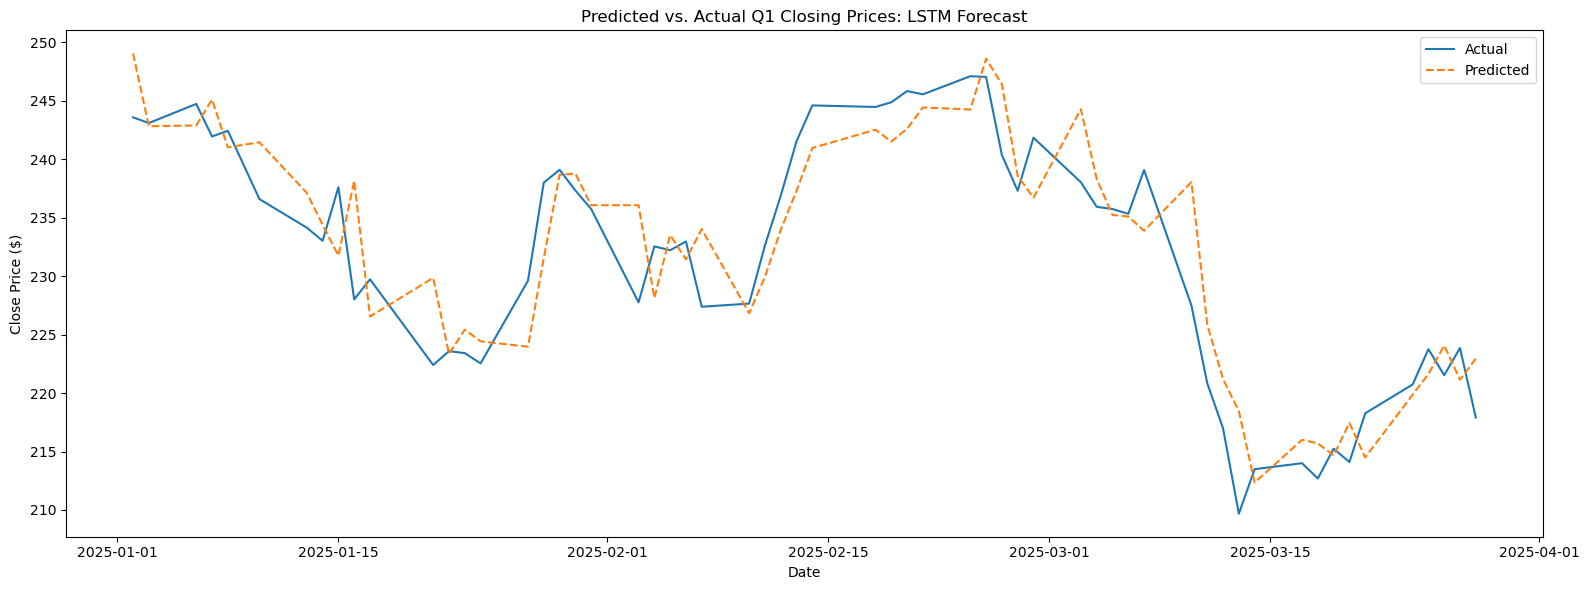


Apple Results
Buy Date: Jan 2, 2025
MAE: 3.3850 | RMSE: 4.1997
R²: 0.8331
Directional Accuracy: 50.12%


In [4]:
#run the model for AAPL only
aapl_result = run_lstm_for_stock('AAPL', 'Apple')

#plot actual vs predicted closing prices for Q1 2025
df = aapl_result['df']
plt.figure(figsize=(16, 6))
plt.plot(df['Close'], label='Actual')
plt.plot(df['Predicted_Close'], label='Predicted', linestyle='--')
plt.title("Predicted vs. Actual Q1 Closing Prices: LSTM Forecast")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.tight_layout()
plt.show()

#print performance metrics
print(f"\n{aapl_result['stock']} Results")
print(f"Buy Date: Jan 2, 2025")
print(f"MAE: {aapl_result['mae']:.4f} | RMSE: {aapl_result['rmse']:.4f}")
print(f"R²: {aapl_result['r2']:.4f}")
print(f"Directional Accuracy: {aapl_result['directional_accuracy'] * 100:.2f}%")